# Commentaries file pre-processing with brands

## Preparing the data

### Pre-processing commentaries

In [1]:
# Imports
import numpy as np
import pandas as pd
from helper_save_load import load_excel_spreadsheet

In [2]:
# Load Forecast and Actual sheets
#dfc = load_excel_spreadsheet('./datasets/Commentaries dataset v2.xlsm', 'All')


#Import dataframes to pickle file (saved previously)

from helper_save_load import load_from_pickle
dfc = load_from_pickle("commentaries_with_brands.pickle")

In [ ]:
dfc.head(2)

#### Formatting month names

In [4]:
month_name=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def format_month(m):
    ym = m.split('/')
    return(month_name[int(ym[1])-1]+'_'+ym[0])
dfc['Month_f'] = dfc['Month'].apply(format_month)

In [ ]:
dfc.head(1)

#### Cleaning commentaries
- Removing punctuation, indesirable words or sentences and copy new comment to a new column


In [ ]:
#Taking a sample of commentaries
df_sample = dfc     #.loc[0:100,:]
NotNull = df_sample['Commentaries'].notna()
df_comments = df_sample[NotNull].loc[:,'Commentaries']
df_comments.head(5)

In [107]:
#Defining codes
SOS = '[SOS]'
EOS = '[EOS]'
NOC = '[NOC]'
MILLIONS_NUM = '[#M]'
THOUSAND_NUM = '[#K]'
NUMBER = '[#]'
PERCENT = '[%]'

In [108]:
#Adding space after +/-, deleting (,),: , deleting 'please see comments above', 
import re
from nltk.stem import PorterStemmer

ps = PorterStemmer()

#Replace patterns of numbers by tokens
resubs = [(r"(\$)?[0-9](\.[0-9]+)?M\b", MILLIONS_NUM),
         (r"(\$)?[0-9]+[Kk]\b", THOUSAND_NUM),
         (r"[0-9]+(\.[0-9]+)?\%", PERCENT),
         (r"\$[0-9]+(\.[0-9]+)?\b", NUMBER)]

raplacements = [('+ [#','+[#'), ('- [#','-[#'),
                ('+','+'),
                ('-','-'),
                ('(',' '),
                (')',' '),
                (':',' '),
                (',',' '),
                ('.',' '),
                (';',''),
                ('\n',' '),
                ('0ml ','0 ml '), ('3ml ','3 ml '), ('4ml ','4 ml '), ('5ml ','5 ml '),
                ('0g ','0 g '), ('3g ','3 g '), ('5g ','5 g '), ('6g ','6 g '),
                ('liption','lipton'),
                ('please see comments above', ''),
                ('please see comments below', ''),
                ('Please see comments above',''),
                ('Please see comments below',''),
               ]

for i, comment in zip(df_comments.index,df_comments):
    if (comment==NOC):
        df_sample.loc[i,'Comment_w'] = NOC
    else:
        for r in resubs:
            comment = re.sub(r[0],r[1], comment)
        comment = comment.lower()
        for r in raplacements:
            comment = comment.replace(r[0],r[1])
        result = re.split(' |/|:', comment)

        result2 = [ps.stem(m) for m in result if m!='']
        df_sample.loc[i,'Comment_w'] = SOS + ' ' + ' '.join(result2) + ' ' + EOS

In [109]:
df_all_com = df_sample[NotNull].loc[:,'Comment_w']

In [110]:
com_corpus = ' '.join(df_all_com.ravel()).split()

In [ ]:
df_sample[NotNull].loc[0:190,['Commentaries', 'Comment_w']]

In [ ]:
dfc.head(3)

### Creating dictionnary

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [114]:
#Create vocabulary and dictionary
vocab = set(com_corpus)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}
print('Size of vocab :', len(vocab))
print('Size of dictionary :', len(word_to_ix))

# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
#trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
#            for i in range(len(test_sentence) - 2)]

Size of vocab : 678
Size of dictionary : 678


In [ ]:
for v in sorted(vocab):
    print (v)

In [116]:
#Save dictionnary and commentaries dataframe to pickle file
from helper_save_load import save_to_pickle
save_to_pickle("commentaries.pickle", (dfc, vocab, word_to_ix, ix_to_word))

### Creating word embedding using pytorch

In [50]:
#Create tri-grams from all comments [word1,word2,target]
trigrams = []
for comment in df_all_com:
    comment_list = comment.split()
    tri = [([comment_list[i], comment_list[i + 1]], comment_list[i + 2])
            for i in range(len(comment_list) - 2)]
    for tr in tri:
        trigrams.append(tr)
# print the first 3, just so you can see what they look like
print(df_all_com[df_all_com.index[0]])
print('\nExamples of trigrams for training:')
for tri in trigrams[:4]:
    print(tri)

[NOC]

Examples of trigrams for training:
(['[SOS]', 'driven'], 'by')
(['driven', 'by'], 'jc')
(['by', 'jc'], 'sobey')
(['jc', 'sobey'], 'metro')


In [51]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 200

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #Embedding matrix: each line is the embedding of one word
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #Parameter matrix embedding and hidden layer
        self.linear2 = nn.Linear(128, vocab_size)  #Parameter matrix between hidden layer and output

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  #get embedding from Embedding matrix
        out = F.relu(self.linear1(embeds))  #
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()   #Negative log likelihood loss (multiclass output with softmax)
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.01)  #stochastic gradient descent   #before 0.001

In [80]:
#Training, you can re-run this function as much time as needed to train more
for epoch in range(20):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    print('epoch %d : Total loss=%.3f' % (epoch, total_loss))
#print(losses)  # The loss decreased every iteration over the training data!

epoch 0 : Total loss=6019.817
epoch 1 : Total loss=5961.326
epoch 2 : Total loss=5914.249
epoch 3 : Total loss=5845.504
epoch 4 : Total loss=5791.026
epoch 5 : Total loss=5733.826
epoch 6 : Total loss=5701.335
epoch 7 : Total loss=5647.558
epoch 8 : Total loss=5587.535
epoch 9 : Total loss=5558.567
epoch 10 : Total loss=5533.625
epoch 11 : Total loss=5473.613
epoch 12 : Total loss=5450.304
epoch 13 : Total loss=5436.706
epoch 14 : Total loss=5391.777
epoch 15 : Total loss=5351.454
epoch 16 : Total loss=5325.113
epoch 17 : Total loss=5289.418
epoch 18 : Total loss=5248.416
epoch 19 : Total loss=5238.990


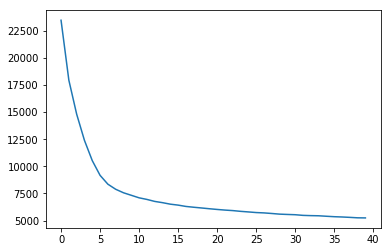

In [81]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(losses);

In [82]:
context, target = trigrams[133]
print('Context:', context)
print('Target:', target)

#Predict next word using model
context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
log_probs = model(context_idxs)

#Get the word that has max probability and display it
result = log_probs.data.numpy().tolist()[0]   #Convert tensor to list
indexmax = result.index(np.max(result)) #get index of the greatest probable word
print('Prediction:', ix_to_word[indexmax])

Context: ['[#]', 'fp']
Target: ad
Prediction: ad


#### Useful function to predict next word, calculate distance between words

In [83]:
def predict_next(context):
    #Predict next word using model
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    log_probs = model(context_idxs)

    #Get the word that has max probability and display it
    result = log_probs.data.numpy().tolist()[0]   #Convert tensor to list
    indexmax = result.index(np.max(result)) #get index of the greatest probable word
    return (ix_to_word[indexmax])

def embedding_word(word):
    word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
    return(model.embeddings(word_idx).data.numpy().tolist()[0])

def distance_words_pytorch(word1,word2):    #between -1 and 1
    from scipy import spatial
    return(1-spatial.distance.cosine(embedding_word(word1), embedding_word(word2)))

def predict_next_multi(context, topn):
    #Predict next word using model
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    log_probs = model(context_idxs)

    #Get the word that has max probability and display it
    result = log_probs.data.numpy().tolist()[0]   #Convert tensor to list
    result_s = sorted(result, reverse=True)
    
    mydict = [(ix_to_word[result.index(p)], np.exp(p)) for p in result_s[0:topn]]
    return (mydict)

In [84]:
predict_next_multi(['by', 'half'], 10)

[('pallet', 0.9846269512220999),
 ('order', 0.006120203477839846),
 ('baselin', 0.001555282882754302),
 ('+[#m]', 0.0013861285217311454),
 ('wm', 0.0013247650488891853),
 ('due', 0.0009583547102707161),
 ('of', 0.0006802531696448085),
 ('[#m]', 0.0005132653876698086),
 ('east', 0.0004776263691683376),
 ('bundl', 0.00031231600188834596)]

In [85]:
predict_next_multi(['driven', 'by'], 10)

[('strong', 0.05640051200655534),
 ('sdm', 0.05501668215557816),
 ('dove', 0.053456151132948986),
 ('pipelin', 0.040397351595921914),
 ('overlay', 0.03554975434339591),
 ('lcl', 0.034128397656997385),
 ('500ct', 0.03342795889283765),
 ('phase', 0.032160861630735615),
 ('promot', 0.03123870666333585),
 ('ooh', 0.030193855815927418)]

In [61]:
predict_next_multi(['by', 'lcl'], 10)

[('[EOS]', 0.2323307453492714),
 ('+[#m]', 0.16541634117325493),
 ('easter', 0.08454624635488212),
 ('60ct', 0.07000552454248384),
 ('[#k]', 0.055112651024521626),
 ('+[#k]', 0.03319487624214638),
 ('-[#m]', 0.019055897469822402),
 ('due', 0.013317986948961483),
 ('east', 0.010084910588059638),
 ('and', 0.009707428581251957)]

In [62]:
predict_next(['[SOS]','driven'])

'by'

In [63]:
predict_next(['expert','segment'])

'sh'

In [79]:
#Basic commentary generation from distance between words
word1 = 'over'
word2 = 'deliveri'
word=''
sentence = [word2]
i=0
while (word!= EOS) & (i<20):
    word = predict_next([word1, word2])
    sentence.append(word)
    word1 = word2
    word2 = word
    i += 1
    
print(' '.join(sentence[0:-1]))

deliveri +[#m] sdm oct order phase in sep 6pack bonu po growth on 355 ml


In [69]:
def closet_words_pytorch(target, topn):   #Does not work well based on the embedding distances
    import operator
    mydict = [(m, distance_words_pytorch(target,m)) for m in list(vocab)]
    sorted_tuples = sorted(mydict, key=operator.itemgetter(1), reverse=True)
    return(sorted_tuples[1:topn])

In [70]:
closet_words_pytorch('driven',10) 

[('faster', 0.22281482467763603),
 ('uniprix', 0.18852167930799202),
 ('deo', 0.17616654634481688),
 ('pog', 0.16812810407354695),
 ('materi', 0.1658039219143258),
 ('off', 0.1585459230168571),
 ('performac', 0.15685728585517456),
 ('miss', 0.15067718002520358),
 ('24', 0.14896671444657628)]

In [62]:
distance_words_pytorch('sobey','lcl')

0.22757552606022324

In [63]:
word = 'doh'
word_to_ix[word]
word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
model.embeddings(word_idx)

tensor([[ 0.3756,  0.0396,  0.1490,  0.1667, -0.8133,  0.0488,  0.7215, -0.6928,
         -1.5910, -1.1907, -0.0978, -0.0095, -0.9462, -1.2306, -0.1153, -0.1944,
         -0.4340,  0.1308, -0.8175,  0.4913]], grad_fn=<EmbeddingBackward>)

#### Save/Load model

In [64]:
#Save model
torch.save(model.state_dict(), './embedding_model_params')

In [65]:
# Load model
#The model class should be defined
model.load_state_dict(torch.load('./embedding_model_params'))
model.eval()

NGramLanguageModeler(
  (embeddings): Embedding(932, 20)
  (linear1): Linear(in_features=40, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=932, bias=True)
)